<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_jaxFlax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [531]:
## Standard libraries
import os
import glob
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy
from google.colab import drive
import time





## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map


## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax




<ipython-input-531-0f7e585b55bf>:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [471]:
# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on CPU


In [472]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [473]:
path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*.csv')
bank_names   = glob.glob(f'{path}*bank.npy')
weight_names = glob.glob(f'{path}*weights.npy')

angles_list  = []
banks_list   = []
weights_list = []
for id, name in enumerate(cvs_names):
    data    = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    bank    = np.load(bank_names[id],mmap_mode="r")
    weights = np.load(weight_names[id],mmap_mode="r")

    angles_list.append(data)
    banks_list.append(bank[1:])
    weights_list.append(weights[1:])


angles_data   = np.stack(angles_list)
banks_data    = np.stack(banks_list)
weights_data  = np.stack(weights_list)

angles_data[:,:,0] = np.sin(angles_data[:,:,0])
angles_data[:,:,1] = np.sin(angles_data[:,:,1]/4.0)

angles_data[:,:,-2] = np.sin(angles_data[:,:,-2])
angles_data[:,:,-1] = np.sin(angles_data[:,:,-1]/4.0)


print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)

(1000, 99, 5)
(1000, 99, 100, 2, 2)
(1000, 99, 100)


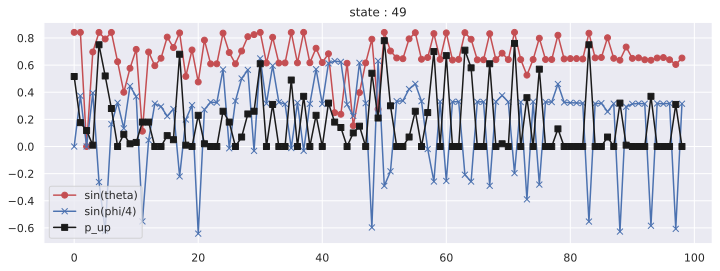

In [474]:
X,y=angles_data[:,:,:3],angles_data[:,:,3:]
state=np.random.randint(X.shape[1])
plt.figure(figsize=(12,4))
plt.plot(np.sin(X[state,:,0]),'o-r',label='sin(theta)')
plt.plot(np.sin(X[state,:,1]),'x-b',label='sin(phi/4)')
plt.plot(X[state,:,2],'s-k',label='p_up')
plt.title(f'state : {state}')
plt.legend()
plt.show()

In [475]:
predic_index  = 80
angles_input  = jnp.array(angles_data[:,:predic_index,:3])
angles_target = jnp.array(angles_data[:, predic_index,3:])
banks         = jnp.array(banks_data[:,predic_index,...])
weights       = jnp.array(weights_data[:,predic_index,:])

print(angles_input.shape)
print(angles_target.shape)
print(banks.shape)
print(weights.shape)

(1000, 80, 3)
(1000, 2)
(1000, 100, 2, 2)
(1000, 100)


In [476]:
# Set the percentage of data to use for validation
validation_split = 0.2

# Determine the number of samples to use for validation
num_validation_samples = int(angles_input.shape[0] * validation_split)

# Split the data into training and validation sets
train_angles_input  = angles_input[:-num_validation_samples]
train_angles_target = angles_target[:-num_validation_samples]
train_banks         = banks[:-num_validation_samples]
train_weights       = weights[:-num_validation_samples]


valid_angles_input  = angles_input[-num_validation_samples:]
valid_angles_target = angles_target[-num_validation_samples:]
valid_banks         = banks[-num_validation_samples:]
valid_weights       = weights[-num_validation_samples:]

#print(train_angles_input.shape)
#print(valid_angles_input.shape)
#print(valid_angles_target.shape)
#print(valid_banks.shape)
#print(valid_banks.shape)

data_train = (train_angles_input, train_angles_target, train_banks, train_weights)
data_valid = (valid_angles_input, valid_angles_target, valid_banks, valid_weights)

In [477]:
# Create a JAX data loader
def data_loader(data, batch_size):
    angles_input, angles_target, banks, weights = data
    num_samples = angles_input.shape[0]
    num_batches = num_samples // batch_size

    def batch_iter():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            yield angles_input[start_idx:end_idx], angles_target[start_idx:end_idx], banks[start_idx:end_idx], weights[start_idx:end_idx]

    return batch_iter()

In [478]:
# Iterate over batches in a training loop
#for epoch in range(2):
#    for train_batch in data_loader(train_angles_input, train_angles_target, train_banks, train_weights, batch_size=4):
#        train_angles_input_batch, train_angles_target_batch, train_banks_batch, train_weights_batch = train_batch
        #print("epoch : ",epoch, "  ",train_angles_input_batch.shape, train_angles_target_batch.shape, train_banks_batch.shape)


In [479]:
class InfoGain():
    def __init__(self):
        pass

    def information_gain(self, angles, banks, weights):
        best_guess = jnp.einsum('ijkl,ij->ikl', banks, weights)
        return self.adaptive_cost_func(angles, banks, weights, best_guess)

    def adaptive_cost_func(self, angles, rhoBank, weights, bestGuess):
        # Creates projector from angles
        povm = self.angles_to_single_qubit_POVM(angles)
        # Computes the entropy of prior and posterior distributions.
        K = self.Shannon_entropy(jnp.einsum('nijk,nkj->ni', povm, bestGuess))
        J = self.Shannon_entropy(jnp.einsum('nijk,nlkj->nil', povm, rhoBank))
        # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
        return jnp.real(K - jnp.einsum("ij,ij->i", J, weights))

    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob = jnp.maximum(prob, epsilon)  # Replace zeros with epsilon
        return jnp.real(jnp.sum(-(prob * jnp.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):

        up_state_vector = jnp.array([jnp.cos(angles[:, 0] / 2), jnp.exp(1j * angles[:, 1]) * jnp.sin(angles[:, 0] / 2)],
                                    dtype=complex)
        up_POVM = jnp.einsum("in,jn->nij", up_state_vector, up_state_vector.conj())
        return jnp.einsum('injk->nijk', jnp.array([up_POVM[:], jnp.eye(2) - up_POVM[:]], dtype=complex))




In [480]:
@jax.jit
def mse(y_true, y_pred):
     #mean over batch
    return jnp.mean(jnp.square(y_true - y_pred))

In [481]:
info_gain = InfoGain()

@jax.jit
def custom_loss(y_true, y_pred, banks, weights, lambda_weight=0.05):
    #print(y_true.shape, y_pred.shape, banks.shape, weights.shape)
    true_info_gains = info_gain.information_gain(y_true, banks, weights)
    pred_info_gains = info_gain.information_gain(y_pred, banks, weights)

    loss_infoGain = 1e4 * jnp.abs(pred_info_gains - true_info_gains)  #!!!!! not clear yet

    # mean  over batch
    loss_infoGain = jnp.mean(loss_infoGain)

    return (1.0 - lambda_weight) *loss_infoGain + lambda_weight * mse(y_true, y_pred)


In [482]:
class GATLayer(nn.Module):
    features : int  # features F'
    N        : int  # number of nodes

    def setup(self):
        self.W = nn.Dense(features=self.features, kernel_init=nn.initializers.glorot_uniform(),use_bias=False)
        self.a = nn.Dense(features=1,kernel_init=nn.initializers.glorot_uniform(),use_bias=False)


    def attention(self, x):
        batch_size, N, F = x.shape
        alpha = jnp.empty((batch_size, N, N))
        for i in range(N):
            for j in range(N):
                e_ij  = self.a(jnp.concatenate((x[:,i,:], x[:,j,:]), -1))
                e_ij = jax.nn.leaky_relu(e_ij, negative_slope=0.2)
                alpha = alpha.at[:,i,j].set(e_ij.flatten())
        return alpha


    def attention_vec(self,x):
        batch_size, N, F = x.shape

        # Repeat x to create (batch_size, N, N, F) tensor
        x_i = jnp.expand_dims(x, axis=2)  # (batch_size, N, 1, F)
        x_j = jnp.expand_dims(x, axis=1)  # (batch_size, 1, N, F)
        x_ij = jnp.concatenate((x_i, x_j), axis=-1)  # (batch_size, N, N, 2F)

        # Apply the attention mechanism to the concatenated tensor
        e_ij = self.a(x_ij)
        e_ij = jax.nn.leaky_relu(e_ij, negative_slope=0.2)

        # Flatten the result and reshape to get the attention matrix
        alpha = jnp.reshape(e_ij, (batch_size, N, N))

        return alpha


    def __call__(self, x):
          adj_matrix = jnp.ones((x.shape[0], self.N,self.N)) # all to all connections
          x = self.W(x)
          # applying self-attention
          alpha_ij = self.attention(x)
          # masking based on "adj_matrix"
          #alpha_ij = jnp.where(adj_matrix == 1., alpha_ij, jnp.ones_like(alpha_ij) * (-9e15))
          # apply nonlinearity
          alpha_ij = nn.softmax(alpha_ij, axis=-1)
          # weighted sum
          h = jnp.einsum("bij,bjl->bil", alpha_ij, x)
          return h


class GATLayerMultilayer(nn.Module):
    heads: int
    hidden:int
    nodes: int

    def setup(self):
        self.gat_layers = [GATLayer(features=self.hidden, N=self.nodes) for _ in range(self.heads)]

    def __call__(self, x):
        gta_list = [gat_layer(x) for gat_layer in self.gat_layers]
        # staking all gat layesrs, creat new tensor on axis=0,
        gta_array = jnp.stack(gta_list)
        # average over all attention layers, on the axis=0
        mean_result = jnp.mean(gta_array, axis=0)
        return nn.sigmoid(mean_result) #???


class NN(nn.Module):
    features: int
    def setup(self):
        self.W = nn.Dense(self.features)
    def __call__(self, x):
        return self.W(x)


class MainModel(nn.Module):
    latent_features: int
    gta_features: int
    final_features: int
    heads: int
    nodes: int


    def setup(self):
        self.dense1 = nn.Dense(self.latent_features)
        self.gat    = GATLayerMultilayer(self.heads, self.gta_features, self.nodes)
        self.dense2 = nn.Dense(64)
        self.dense3 = nn.Dense(32)
        self.dense4 = nn.Dense(self.final_features)

    def __call__(self, x):
        x = nn.relu(self.dense1(x)) # (batch_size, nodes=50, 3) --> (batch_size, nodes=50, 8)
        #x = self.gat(x)
         #--- aggregation     (batch_size, nodes=50, F)   --> (batch_size, 1 , 8)
        x = jnp.mean(x, axis=1)
        x = nn.relu(self.dense2(x))
        x = nn.relu(self.dense3(x))
        #x = jnp.reshape(x, (x.shape[0], -1))  # Flatten
        x = self.dense4(x)
        return x

In [483]:
# create the model

heads           = 1
latent_features = 8
gta_features    = 8
final_features  = 2
nodes           = predic_index
batch_size      = 64


net = MainModel(latent_features=latent_features,
                      gta_features=gta_features,
                      final_features=final_features,
                      heads=heads,
                      nodes=nodes)



In [484]:
#initialize network parameters and solver state
LEARNING_RATE = 0.001
solver        = optax.adam(LEARNING_RATE)
rng           = jax.random.PRNGKey(0)
dummy_data    = jnp.ones((batch_size, nodes, 3))
params        = net.init(rng, dummy_data)
solver_state  = solver.init(params)

In [485]:

#@jax.jit
def predict(params, inputs):
  return net.apply(params, inputs)


@jax.jit
def loss_accuracy(params, data):
    """Computes loss over a batch.
    Args:
      params: parameters of the model.
      data: tuple of (angles, banks, weights).

    Returns:
      loss: float
    """
    angles_input, angles_target, banks, weights = data
    angles_predict = predict(params, angles_input)
    loss           = custom_loss(angles_target, angles_predict, banks, weights)
    return loss


In [486]:
@jax.jit
def train_step(params, solver_state, batch):
  # Performs a one step update.
  loss, grad            = jax.value_and_grad(loss_accuracy, has_aux=False)(params, batch)
  updates, solver_state = solver.update(grad, solver_state, params)
  params                = optax.apply_updates(params, updates)
  return params, solver_state, loss

# Validation function
@jax.jit
def evaluate(params, batch):
    return loss_accuracy(params, batch)


In [487]:
#train_batch = next(data_loader(train_angles_input, train_angles_target, train_banks, train_weights, batch_size))
#x,y,z,t = train_batch
#x.shape
#out = predict(params, train_batch[0])

In [488]:

N_EPOCHS     = 1000
train_losses = []
valid_losses = []

for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    start_time = time.time()  # Record start time for the epoch
    train_losses_epoch = []
    valid_losses_epoch = []

    for train_batch in data_loader(data_train, batch_size):
        params, solver_state, train_loss = train_step(params, solver_state, train_batch)
        train_losses_epoch.append(train_loss)

    for valid_batch in data_loader(data_valid, batch_size):
        valid_loss = evaluate(params, valid_batch)
        valid_losses_epoch.append(valid_loss)

    valid_losses.append(np.mean(valid_losses_epoch))
    train_losses.append(np.mean(train_losses_epoch))

    end_time = time.time()  # Record end time for the epoch
    epoch_time = end_time - start_time
    if epoch % 50 == 0:
        tqdm.write(f"Epoch {epoch + 1}/{N_EPOCHS}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Time: {epoch_time:.4f} seconds")


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000, Training Loss: 0.6169, Validation Loss: 0.0859, Time: 5.1979 seconds
Epoch 51/1000, Training Loss: 0.3450, Validation Loss: 0.0613, Time: 0.0548 seconds
Epoch 101/1000, Training Loss: 0.3409, Validation Loss: 0.0568, Time: 0.0546 seconds
Epoch 151/1000, Training Loss: 0.3246, Validation Loss: 0.0586, Time: 0.0532 seconds
Epoch 201/1000, Training Loss: 0.3207, Validation Loss: 0.0576, Time: 0.0784 seconds
Epoch 251/1000, Training Loss: 0.3211, Validation Loss: 0.0577, Time: 0.0763 seconds
Epoch 301/1000, Training Loss: 0.3081, Validation Loss: 0.0565, Time: 0.0552 seconds
Epoch 351/1000, Training Loss: 0.3015, Validation Loss: 0.0575, Time: 0.0549 seconds
Epoch 401/1000, Training Loss: 0.3032, Validation Loss: 0.0567, Time: 0.0580 seconds
Epoch 451/1000, Training Loss: 0.3000, Validation Loss: 0.0573, Time: 0.0765 seconds
Epoch 501/1000, Training Loss: 0.3000, Validation Loss: 0.0575, Time: 0.0842 seconds
Epoch 551/1000, Training Loss: 0.2915, Validation Loss: 0.0588, Time

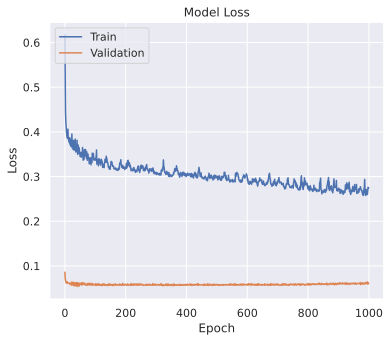

In [489]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [490]:
def save_model_params(params, save_path):
    with open(save_path, "wb") as f:
        pickle.dump(params, f)

def save_training_losses(train_losses, valid_losses, losses_path):
    with open(losses_path, "wb") as f:
        pickle.dump((train_losses, valid_losses), f)

In [491]:

save_path = "/content/drive/MyDrive/SL_data/trained_model_params.pkl"
save_model_params(params, save_path)


losses_path = "/content/drive/MyDrive/SL_data/training_losses_valid_losses.pkl"
save_training_losses(train_losses, valid_losses, losses_path)


In [497]:
print(valid_angles_input.shape)
print(valid_angles_target.shape)

(200, 80, 3)
(200, 2)


In [522]:
true_angle = []
pred_angle = []
for input in data_loader(data_valid, 32):
    #print(input[0].shape)
    pred_angle.append(predict(params, input[0]))
    true_angle.append(input[1])



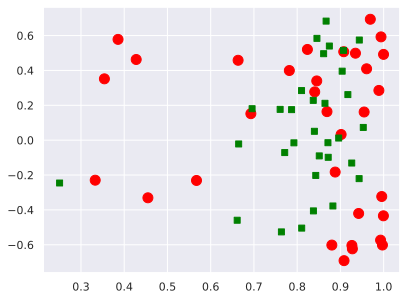

In [526]:
i = np.random.randint(len(true_angle));
plt.scatter(true_angle[i][:,0],true_angle[i][:,1], color='red', s =100, marker='o', label='True');
plt.scatter(pred_angle[i][:,0],pred_angle[i][:,1], color='green', marker='s', label='predict');

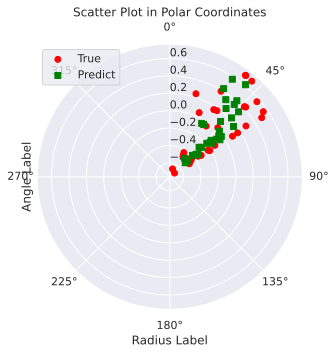

In [530]:

# Random index (replace this with your actual index)
i = np.random.randint(len(true_angle))

# Convert Cartesian coordinates to polar coordinates
true_radius = np.sqrt(true_angle[i][:, 0]**2 + true_angle[i][:, 1]**2)
true_theta = np.arctan2(true_angle[i][:, 1], true_angle[i][:, 0])

pred_radius = np.sqrt(pred_angle[i][:, 0]**2 + pred_angle[i][:, 1]**2)
pred_theta = np.arctan2(pred_angle[i][:, 1], pred_angle[i][:, 0])



# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Scatter plot for true angles
ax.scatter(true_angle[i][:, 0], true_angle[i][:, 1], color='red',  marker='o', label='True')

# Scatter plot for predicted angles
ax.scatter(pred_angle[i][:, 0], pred_angle[i][:, 1], color='green', marker='s', label='Predict')

# Set the origin to the center
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Add labels and legend
ax.set_rlabel_position(0)
ax.set_xlabel('Radius Label')
ax.set_ylabel('Angle Label')
ax.set_title('Scatter Plot in Polar Coordinates')
ax.legend()

# Show the plot
plt.show()


In [534]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


AttributeError: ignored

Error in callback <function _draw_all_if_interactive at 0x7c785d1d2200> (for post_execute):


AttributeError: ignored

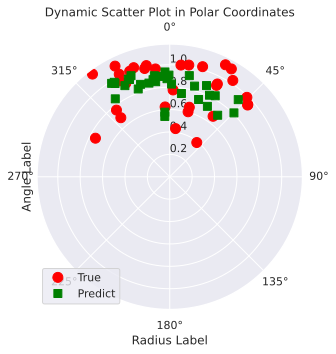

In [535]:

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
scatter_true, = ax.plot(true_theta, true_radius, 'o', color='red', markersize=10, label='True')
scatter_pred, = ax.plot(pred_theta, pred_radius, 's', color='green', markersize=8, label='Predict')

# Set the origin to the center
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Add labels and legend
ax.set_rlabel_position(0)
ax.set_xlabel('Radius Label')
ax.set_ylabel('Angle Label')
ax.set_title('Dynamic Scatter Plot in Polar Coordinates')
ax.legend()

# Animation update function
def update(frame):
    i = np.random.randint(len(true_angle))
    scatter_true.set_data(true_theta, true_radius)
    scatter_true.set_offsets(np.column_stack([true_theta, true_radius]))
    scatter_pred.set_data(pred_theta, pred_radius)
    scatter_pred.set_offsets(np.column_stack([pred_theta, pred_radius]))
    ax.set_title(f'Frame {frame}: Dynamic Scatter Plot')

# Create the animation
animation = FuncAnimation(fig, update, frames=range(100), interval=500, repeat=False)

# Display the animation in Colab
display(HTML(animation.to_jshtml()))